In [3]:
# Imports
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [18]:
class ASLDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_mapping = {}  

        # collect image paths
        for filename in os.listdir(root_dir):
            parts = filename.split('_')
            label = parts[0]  # extract label
            self.image_paths.append(os.path.join(root_dir, filename))
            self.labels.append(label)

        # continuous label mapping
        unique_labels = sorted(set(self.labels))
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = [self.label_mapping[label] for label in self.labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L') 
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


root_dir = 'new_data_50x50_split/'
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))  # image norm
])

# create datasets
train_dataset = ASLDataset(root_dir=os.path.join(root_dir, 'train'), transform=transform)
val_dataset = ASLDataset(root_dir=os.path.join(root_dir, 'val'), transform=transform)
test_dataset = ASLDataset(root_dir=os.path.join(root_dir, 'test'), transform=transform)


In [19]:
# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
# CNN class
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=24):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
# infer number of classes
def get_num_classes(dataset):
    unique_labels = set()
    for _, label in dataset:
        unique_labels.add(label)
    return len(unique_labels)

In [22]:
num_classes = get_num_classes(train_dataset)
model = SimpleCNN(num_classes=num_classes)
print("Model initialized")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Optimizer initialized")

# metric tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, labels in train_loader_tqdm:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=running_loss/len(train_loader))
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {train_accuracy}%")

    # val loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {epoch_val_loss}, Validation Accuracy: {val_accuracy}%")

print("Training complete")

Model initialized
Optimizer initialized


Epoch 1/10: 100%|█████████████| 4183/4183 [03:43<00:00, 18.70batch/s, loss=2.28]


Epoch 1, Loss: 2.2796237825235908, Accuracy: 29.656496533588335%
Validation Loss: 1.8327061783111216, Validation Accuracy: 42.281411239715524%


Epoch 2/10: 100%|█████████████| 4183/4183 [03:45<00:00, 18.59batch/s, loss=1.69]


Epoch 2, Loss: 1.6904425226613262, Accuracy: 46.573183122161126%
Validation Loss: 1.6415876267745741, Validation Accuracy: 48.16971133733092%


Epoch 3/10: 100%|█████████████| 4183/4183 [03:50<00:00, 18.14batch/s, loss=1.53]


Epoch 3, Loss: 1.5267006032295327, Accuracy: 51.30737508964858%
Validation Loss: 1.5367383034598734, Validation Accuracy: 51.68386556965556%


Epoch 4/10: 100%|█████████████| 4183/4183 [08:19<00:00,  8.37batch/s, loss=1.44]


Epoch 4, Loss: 1.4360819695784148, Accuracy: 53.97068491513268%
Validation Loss: 1.4888491866447722, Validation Accuracy: 52.848277785525035%


Epoch 5/10: 100%|█████████████| 4183/4183 [07:24<00:00,  9.40batch/s, loss=1.37]


Epoch 5, Loss: 1.374727873747468, Accuracy: 55.805492469519486%
Validation Loss: 1.4213010923253786, Validation Accuracy: 54.94700878538558%


Epoch 6/10: 100%|█████████████| 4183/4183 [23:55<00:00,  2.91batch/s, loss=1.32]


Epoch 6, Loss: 1.323943918696893, Accuracy: 57.31457685871384%
Validation Loss: 1.403166770802161, Validation Accuracy: 54.856365918281966%


Epoch 7/10: 100%|█████████████| 4183/4183 [17:48<00:00,  3.91batch/s, loss=1.29]


Epoch 7, Loss: 1.287121331324111, Accuracy: 58.461331580205595%
Validation Loss: 1.3760144281945499, Validation Accuracy: 56.06609956770325%


Epoch 8/10: 100%|█████████████| 4183/4183 [03:13<00:00, 21.62batch/s, loss=1.25]


Epoch 8, Loss: 1.2542982830004974, Accuracy: 59.26592756394932%
Validation Loss: 1.3859944980811647, Validation Accuracy: 56.00683307767397%


Epoch 9/10: 100%|█████████████| 4183/4183 [03:12<00:00, 21.69batch/s, loss=1.23]


Epoch 9, Loss: 1.228862437881581, Accuracy: 60.171378197465934%
Validation Loss: 1.3692791667271618, Validation Accuracy: 56.69362710918979%


Epoch 10/10: 100%|█████████████| 4183/4183 [03:13<00:00, 21.57batch/s, loss=1.2]


Epoch 10, Loss: 1.2041159285018241, Accuracy: 60.741393736552716%
Validation Loss: 1.3216237371980546, Validation Accuracy: 57.45014642309302%
Training complete


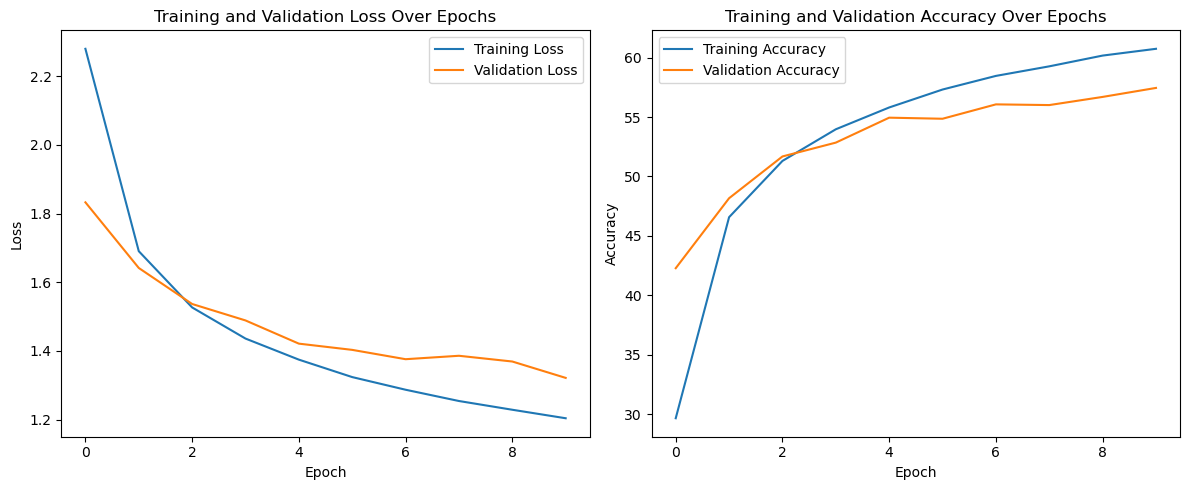

In [23]:
# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

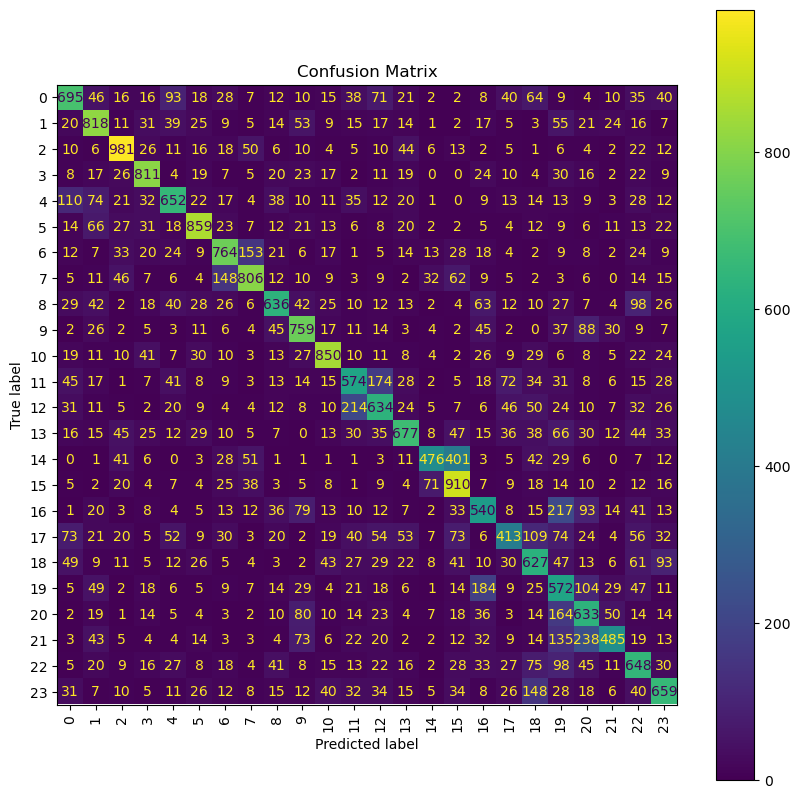

In [24]:
# confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=[i for i in range(num_classes)])
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size
cmd.plot(ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()